In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import binom
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
##Generate a list of RBP target genes from eCLIP peaks and GTF file
eclip='/Path to save directory/RBFOX2_eclip_peaks.bed'
from pybedtools import BedTool
gtf=BedTool('/Path to save directory/gencode.v19.annotation.gtf')
df=BedTool(eclip)
df1=df.intersect(gtf, wa=True,wb=True)
df1.saveas('RBFOX2_annotated.bed')


ValueError: invalid literal for int() with base 10: '0-27-g6ae9016\n'

In [4]:
df=pd.read_csv('RBFOX2_annotated.bed', sep='\t', header=None)
df=df[df[12]=='gene']
df['gene']=list(map(lambda x: x.split('transcript_name "')[1].split('";')[0], df[18]))
clip_genes=df.drop_duplicates('gene')['gene'].to_list()

In [5]:
##import CSV data for RBP of interest and control and merge into a single df
APO=pd.read_csv('/Path to save directory/APOBEC_control_cDNA_df.csv')
RBFOX=pd.read_csv('/Path to save directory/RBFOX2_cDNA_df.csv')
APO=APO[['0','1','3','4','7','key2','miss_base','total_match','total_miss','total_fraction','total_confidence']]
RBFOX=RBFOX[['0','1','3','4','7','key2','miss_base','total_match','total_miss','total_fraction','total_confidence']]
df=RBFOX.merge(APO, left_on=['0','1'], right_on=['0','1'], suffixes=['_RBFOX2','_APO'])
APO=0
RBFOX2=0

In [6]:
def base_filter(df):
    if df['3_RBFOX2']=="C":
        if df['miss_base_APO']=='T':
            return 1
        elif df['miss_base_RBFOX2']=='T':
            return 1
        else: return 0
    else:
        return 0

In [7]:
##Filter for only C>T edits
df['base_filter']=df.apply(base_filter, axis=1)
df=df[df['base_filter']==1]
#Filter for at least 10 matched bases at each position
df1=df[df['total_match_APO']>=10].copy()
df1=df1[df1['total_match_RBFOX2']>=10]

In [8]:
df1['ENST']=list(map(lambda x: x.split('.')[0], df1['0']))

In [9]:
def hit4_filter(df):
    if (df['total_confidence_APO']>=0.99)&(df['total_confidence_RBFOX2']>=0.99)&(df['miss_base_RBFOX2']=='T')&(df['miss_base_APO']=='T'):
        return 'both'
    elif (df['total_confidence_APO']>=0.99)&(df['miss_base_APO']=='T'):
            return 'APO'
    elif (df['total_confidence_RBFOX2']>=0.99)&(df['miss_base_RBFOX2']=='T'):
        return 'RBFOX'
    elif (df['total_confidence_APO']<=0.05)&(df['total_confidence_RBFOX2']<=0.05):
        return 'none'
    else:
        return '?'

In [10]:
#Find 0.99 confidence sites
df1['hits4']=df1.apply(hit4_filter, axis=1)

In [11]:
#Assign Genes to ENST labels
genes=pd.read_csv('/Path to save directory/ENSEMBL_Gene_and_ENST_names.txt')
mapping = dict(genes[['Transcript stable ID', 'Gene name']].values)
df1['gene'] = df1.ENST.map(mapping)

In [12]:
#Counts number of edit sites per transcript
counts_df_99=pd.DataFrame()
enst_list=set(df1['ENST'])
for i in enst_list:
    tmp=df1[df1['ENST']==i]
    tmp2=pd.DataFrame(tmp['hits4'].value_counts())
    tmp2=tmp2.transpose()
    tmp2['ENST']=i
    tmp2['mean_coverage_FOX']=(tmp['total_match_RBFOX2'].mean()+tmp['total_miss_RBFOX2'].mean())/2
    tmp2['mean_coverage_APO']=(tmp['total_match_APO'].mean()+tmp['total_miss_APO'].mean())/2
    tmp.reset_index(inplace=True)
    gene_name=tmp.loc[0,'gene']
    tmp2['gene']=gene_name
    counts_df_99=pd.concat([counts_df_99, tmp2])

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [13]:
##Saves count matrix (backup)
counts_df_99.to_csv('/Path to save directory/counts_df.csv')

In [14]:
#Imports backup file
counts_df_99=pd.read_csv('/Path to save directory/counts_df.csv')

In [15]:
#calculates transcript averages and filters for highest 2 expressed ENST per gene name
counts_df_99.fillna(0, inplace=True)
counts_df_99['hits']=counts_df_99['APO']+counts_df_99['RBFOX']
counts_df_99['sum']=counts_df_99['APO']+counts_df_99['RBFOX']+counts_df_99['none']+counts_df_99['both']+counts_df_99['?']
counts_df_99['ratio']=counts_df_99['RBFOX']/counts_df_99['hits']
counts_df2_99=counts_df_99[counts_df_99['sum']>=25]
counts_df2_99=counts_df2_99[['ENST','RBFOX','APO','both','?','none','gene','hits','sum','ratio','mean_coverage_FOX','mean_coverage_APO']]
counts_df2_99.sort_values(['gene','mean_coverage_FOX'], inplace=True)
df=counts_df2_99.groupby('gene').tail(n=2)
df.fillna(0, inplace=True)
df['diff']=df.groupby('gene')['ratio'].diff().sort_index()
df['abs']=df['diff'].abs()

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be s

In [16]:
##filters for average coverage of 20 reads per C across ENST
df=df[df['mean_coverage_FOX']>=20]
df=df[df.duplicated('gene',keep=False)]
df.fillna(0, inplace=True)
df['diff']=df.groupby('gene')['ratio'].diff().sort_index()
df['abs']=df['diff'].abs()

In [17]:
df['diff2']=df['RBFOX']-df['APO']

In [18]:
##sorts df based on expression values and labels as isoform 1 and 2
df.sort_values(['gene','diff2'], inplace=True)
df['hue2']=1
df['hue2'][df.duplicated('gene')]=2

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
#Filters for eCLIP genes
final=df[df['gene'].isin(clip_genes)].copy()

In [20]:
heatmap1_data = pd.pivot_table(final, values=['RBFOX','APO'], 
                     index=['gene'], 
                     columns='hue2')

In [21]:
heatmap1_data.sort_values([('APO', 1),('APO',2),('RBFOX', 1),('RBFOX',2)],inplace=True)

In [22]:
heatmap1_data=np.log2(heatmap1_data)
from numpy import inf
heatmap1_data[heatmap1_data == -inf] = 0
heatmap1_data.fillna(0, inplace=True)


/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


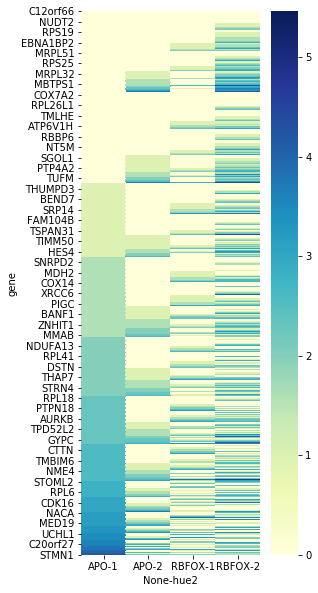

In [23]:
plt.figure(figsize=(4,10))
fig=sns.heatmap(heatmap1_data,cmap="YlGnBu").get_figure()
fig.savefig("/Path to save directory/Isoform_heatmap_log2.svg")